# Irregular Image Data with Pre-trained ResNet model

Data Source: http://vision.stanford.edu/aditya86/ImageNetDogs/

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. Contents of this dataset:

    Number of categories: 120
    Number of images: 20,580
    Annotations: Class labels, Bounding boxes

As an example, we will focus on distinguishing between Shih-Tzu (214 images) and Blenheim spaniel (188 images).

Key concepts illustrated

 * Load images using `torchvision.datasets.ImageFolder`

 * More preprocessing tools in `torchvision.transforms`

 * Transfer learning using a pre-trained CNN in `torchvision.models`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from torchvision import transforms, datasets, models
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

torch.manual_seed(53)
np.random.seed(432)

%matplotlib inline

## Load the image data with pre-processing

In [2]:
root = 'C:/Users/ywang254/OneDrive - University of Tennessee/Teaching/JupyterNotebooks/data/DogBreeds'
data_all = datasets.ImageFolder(root=root, transform=transforms.ToTensor())

In [3]:
data_all.class_to_idx

{'Blenheim_spaniel': 0, 'Shih-Tzu': 1}

In [4]:
print(data_all)

Dataset ImageFolder
    Number of datapoints: 402
    Root location: C:/Users/ywang254/OneDrive - University of Tennessee/Teaching/JupyterNotebooks/data/DogBreeds
    StandardTransform
Transform: ToTensor()


In [5]:
print(data_all.data) # cannot directly access the data like the pre-existing datasets

AttributeError: 

Manually examine the image sizes, mean and standard devaiation of pixel values.
Images that are extremely small should be removed (large images can be resized). 

In [6]:
image_mean = []
image_szs  = []

for image, label in DataLoader(data_all, batch_size=1, shuffle=False):
    image_mean.append(image.mean(dim=[0,2,3])) # the first dimension is batch size
    image_szs .append(tuple(image.size()[2:]))

In [7]:
means = torch.stack(image_mean).mean(dim = 0)
stds  = torch.stack(image_mean).std (dim = 0)

print(f'Mean values of each channel: {means}')
print(f'Standard deviations of each channel: {stds }')

Mean values of each channel: tensor([0.4652, 0.4316, 0.3783])
Mean values of each channel: tensor([0.1084, 0.1037, 0.1108])


(array([ 30.,  75., 281.,   7.,   2.,   2.,   1.,   2.,   0.,   2.]),
 array([ 134. ,  286.8,  439.6,  592.4,  745.2,  898. , 1050.8, 1203.6,
        1356.4, 1509.2, 1662. ]),
 <BarContainer object of 10 artists>)

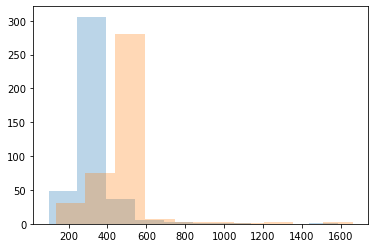

In [8]:
plt.hist(np.stack(image_szs).min(axis = 1), alpha = 0.3) # Use min to account for rectangular images
plt.hist(np.stack(image_szs).max(axis = 1), alpha = 0.3)

Split the data randomly into training and test sets. Since `ImageFolder` lazily load the data in its `__getitem__` method, we can load the data twice using different transforms, and subset into the training and test sets.

In [9]:
# Re-load the data with transformations
# - transforms.CenterCrop: crop the longest side to x pixels at center
# - transforms.Resize: resize shortest side to x pixels
# - transforms.RandomRotation: randomly rotate within (min,max) or +/-degrees range
# - transforms.RandomHorizontalFlip: randomly horizontal flip with given probability
# - transforms.RandomCrop: crop the image to given size, and optionally pad the edge of the image
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.Resize(224),
                           transforms.CenterCrop(224),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.Resize(224),
                           transforms.CenterCrop(224),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])
                       
train_data = datasets.ImageFolder(root=root, transform=train_transforms)
test_data  = datasets.ImageFolder(root=root, transform=test_transforms )

class_names = train_data.class_to_idx
class_idx_to_names = dict((j,i) for i,j in class_names.items())

sep = np.random.choice([True,False], size = len(train_data), p = [0.8,0.2])
train_data = Subset(train_data, np.where(sep)[0])
test_data  = Subset(test_data, np.where(~sep)[0])

batch_size = 10
train_iterator = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iterator = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print(class_names)
print(class_idx_to_names)
print(f'Training images available: {len(train_iterator)}')
print(f'Testing images available:  {len(test_iterator)}')

{'Blenheim_spaniel': 0, 'Shih-Tzu': 1}
{0: 'Blenheim_spaniel', 1: 'Shih-Tzu'}
Training images available: 31
Testing images available:  10


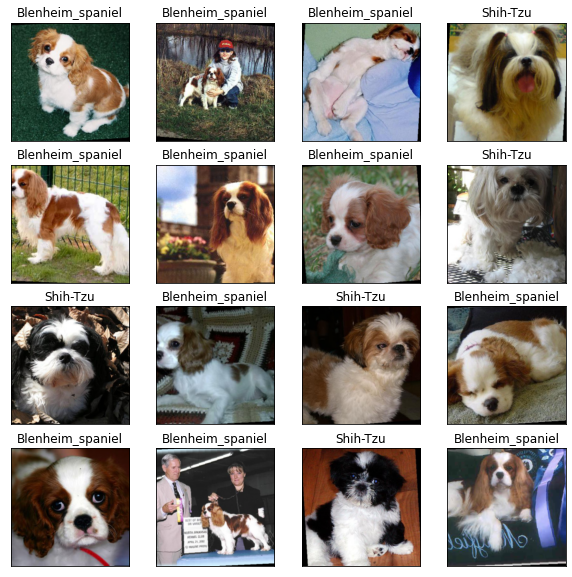

In [10]:
def img_plotter(img_list, lab_list):
    ncols = 4
    nrows = int(np.ceil(len(img_list)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5))
    for i in range(len(img_list)):
        image = img_list[i]
        label = lab_list[i]
        ax = axes.flat[i]
        if len(image.shape) == 3:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        else:
            ax.imshow(image.numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])

# View the first few images
count = 0
img_list = []
lab_list = []
for image, label in DataLoader(train_data, shuffle=True, batch_size=1):
    img_list.append(image[0,:,:,:] * stds.reshape(3,1,1) + means.reshape(3,1,1))
    lab_list.append(class_idx_to_names[label.item()])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Download the pre-trained ResNet Model

In [11]:
resnet18 = models.resnet18(pretrained=True) # This ResNet is only 18 layers deep
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Freeze feature parameters

Setting `requires_grad` to False will prevent backpropagation from modifying the pre-trained weights & biases.

In [12]:
for param in resnet18.parameters():
    param.requires_grad = False

Overwrite the linear layer of the pre-trained model with a new linear layer.

In [13]:
resnet18.fc = nn.Sequential(nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(256, 2),
                            nn.LogSoftmax(dim=1))
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Count the trainable parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(resnet18)

  131072
     256
     512
       2
________
  131842


## Define loss and optimization functions

In [15]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

## Train the model

In [16]:
start_time = time.time()

train_losses = []

for i in range(num_epochs):
    for j, (img_list, lab_list) in enumerate(train_iterator):

        lab_pred = resnet18(img_list)
        loss = criterion(lab_pred, lab_list)

        if j%100 == 0:
            print(f'epoch: {i:2}  batch: {j:4} [{batch_size*j:6}/{len(train_data)}]  loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:    0 [     0/310]  loss: 0.72180575
epoch:  1  batch:    0 [     0/310]  loss: 0.02887736
epoch:  2  batch:    0 [     0/310]  loss: 0.37865382
epoch:  3  batch:    0 [     0/310]  loss: 0.15854120
epoch:  4  batch:    0 [     0/310]  loss: 0.03001164
epoch:  5  batch:    0 [     0/310]  loss: 0.05515173
epoch:  6  batch:    0 [     0/310]  loss: 0.02559723
epoch:  7  batch:    0 [     0/310]  loss: 0.01374297
epoch:  8  batch:    0 [     0/310]  loss: 0.04824462
epoch:  9  batch:    0 [     0/310]  loss: 0.00077278
epoch: 10  batch:    0 [     0/310]  loss: 0.02143487
epoch: 11  batch:    0 [     0/310]  loss: 0.01362747
epoch: 12  batch:    0 [     0/310]  loss: 0.76945341
epoch: 13  batch:    0 [     0/310]  loss: 0.02159674
epoch: 14  batch:    0 [     0/310]  loss: 0.12261444
epoch: 15  batch:    0 [     0/310]  loss: 0.08838481
epoch: 16  batch:    0 [     0/310]  loss: 0.70015377
epoch: 17  batch:    0 [     0/310]  loss: 0.00112950
epoch: 18  batch:    0 [    

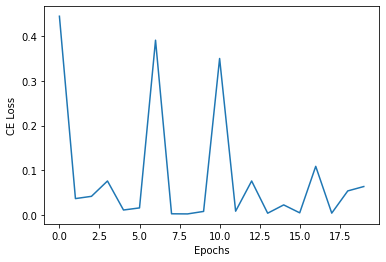

In [17]:
num_epochs = len(train_losses)
if num_epochs == len(train_losses):
    plt.plot(torch.Tensor(train_losses).detach().numpy())
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
else:
    raise 'Training is not finished.'

In [18]:
# save the trained model
torch.save(resnet18.state_dict(), 'ResNet_DogBreeds.pt')

## Evaluate the model

In [19]:
model2 = models.resnet18() # note here is not pre-trained
model2.fc = nn.Sequential(nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(256, 2),
                            nn.LogSoftmax(dim=1))
model2.load_state_dict(torch.load('ResNet_DogBreeds.pt'))

<All keys matched successfully>

In [20]:
def calc_accuracy(y_pred, y):
    which = y_pred.argmax(1)
    correct = (which == y).float().mean() * 100
    return correct

start_time = time.time()

test_losses = []
test_accuracy = []

model2.eval()

with torch.no_grad():
    for j, (img_list, lab_list) in enumerate(test_iterator):
        lab_pred = model2(img_list)

        loss = criterion(lab_pred, lab_list)
        test_losses.append(loss)

        acc = calc_accuracy(lab_pred, lab_list)
        test_accuracy.append(acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 7 seconds


Text(0, 0.5, 'CE Loss')

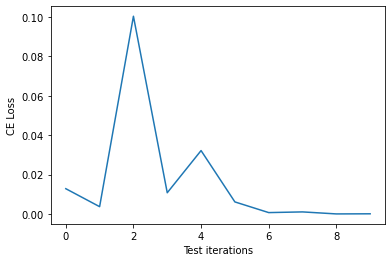

In [21]:
plt.plot(torch.Tensor(test_losses).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('CE Loss')

Text(0, 0.5, 'Correct classifications (%)')

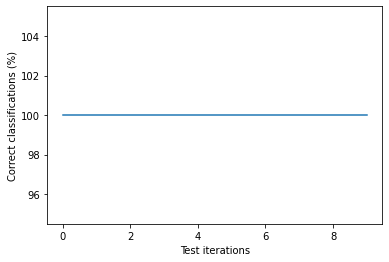

In [22]:
plt.plot(torch.Tensor(test_accuracy).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('Correct classifications (%)')

Make the confusion matrix using all of the test data

In [23]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
with torch.no_grad():
    for X_test, y_test in test_load_all:
        test_pred_all = model2(X_test)
        correct = (test_pred_all.argmax(1) == y_test)

test_pred_all = test_pred_all.detach().numpy()
correct = correct.detach().numpy()

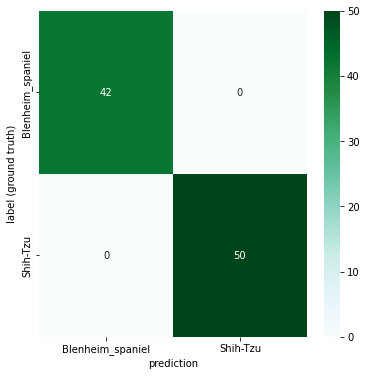

In [24]:
arr = confusion_matrix(test_pred_all.argmax(1), y_test.detach().numpy())

df_cm = pd.DataFrame(arr, [class_idx_to_names[i] for i in range(2)], [class_idx_to_names[i] for i in range(2)])
plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## Examine the top misses

Top misses are defined as the instances that are missclassified but have high confidence in the classified result.

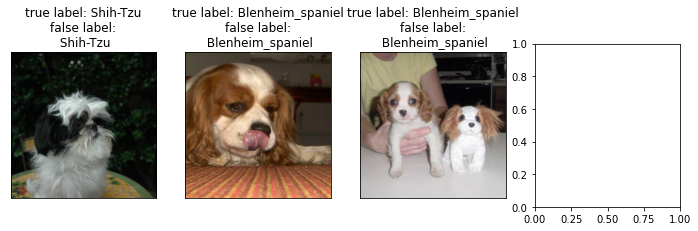

In [25]:
test_class_all  = test_pred_all.argmax(1).astype(int)
test_class_true = y_test.detach().numpy()
test_probs_all  = np.exp(np.max(test_pred_all, axis = 1))
top_misses      = np.argsort(test_probs_all * (1 - correct))[::-1]

img_list = []
lab_list = []
for i in range(3):
    j = top_misses[i]
    img_list.append( (X_test[j] * stds.reshape(3,1,1) + means.reshape(3,1,1))  ) # re-normalize
    lab_list.append( f'true label: {class_idx_to_names[test_class_true[j]]}\nfalse label:\n {class_idx_to_names[test_class_all[j]]}' )
img_plotter(img_list, lab_list)
plt.gcf().set_size_inches(12,3)
plt.subplots_adjust(wspace=.2)

## Examine the effect of the trained blocks

In [28]:
test_class_all  = test_pred_all.argmax(1).astype(int)
test_class_true = y_test.detach().numpy()
test_probs_all  = np.exp(np.max(test_pred_all, axis = 1))

In [29]:
first_part = nn.Sequential(resnet18.conv1, resnet18.bn1, resnet18.relu, resnet18.maxpool, 
                           resnet18.layer1)

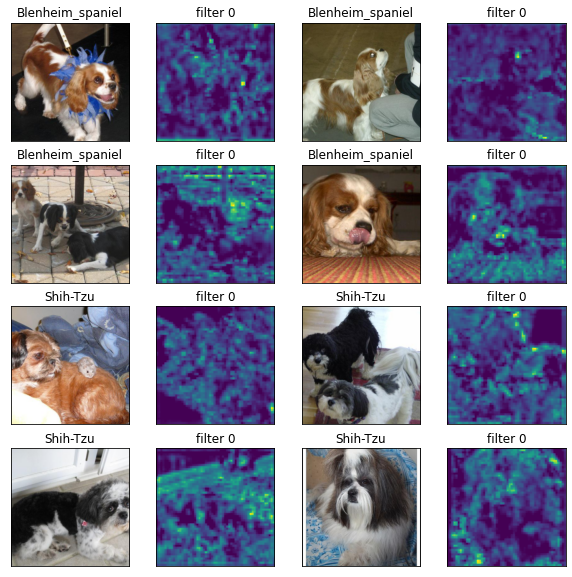

In [30]:
img_list = []
lab_list = []
for i in range(0, 84, 11):
    img_list.append( X_test[i] * stds.reshape(-1,1,1) + means.reshape(-1,1,1) )
    lab_list.append( class_idx_to_names[test_class_true[i]] )
    for j in range(1):
        img_list.append( first_part(X_test[i].unsqueeze(0)).detach()[0,0,:,:] )
        lab_list.append( f'filter {j}' )
img_plotter(img_list, lab_list)